In [1]:
from Regression import Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- 首先进行数据导入
- colums是每一列的列名，方便之后读取数据
- df：pandas读取数据后存储的对象
- delimiter=r'\s+'是为了加分隔以消除NaN

In [2]:
columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df=pd.read_table('housing.data',names=columns,delimiter=r'\s+')

- 接下来进行数据分析
- 调用plt.scatter实现散点图

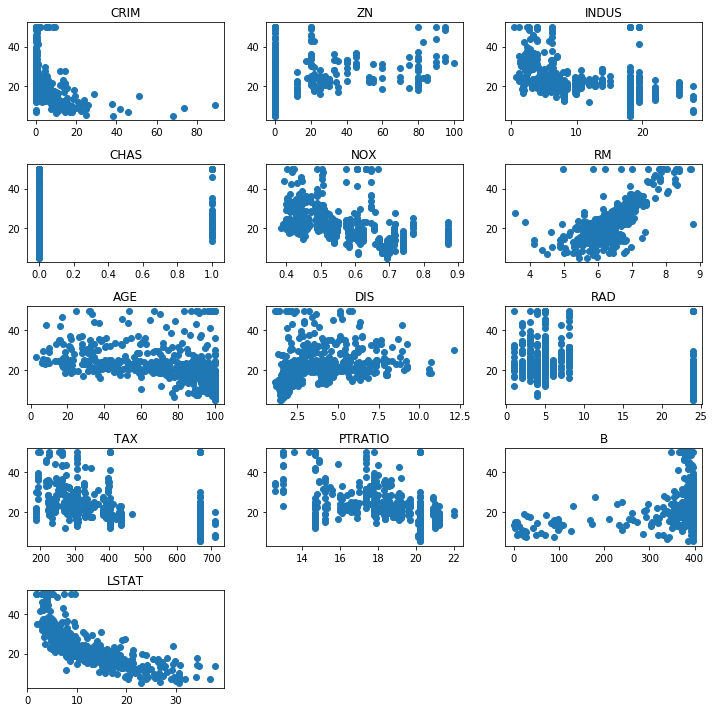

In [3]:
import math

cols=3
rows=math.ceil(13/cols)

plt.figure(figsize=(10,10))
#用for循环画出所有有关MEDV的散点图
for idx in range(13):
    plt.subplot(rows,cols,idx+1)
    plt.scatter(df[columns[idx]],df['MEDV'])
    plt.title(columns[idx])
plt.tight_layout()

- 从上图可知LSTAT、RM两个变量更MEDV有较强相关性
- 其中LSTAT为负相关，RM为正相关
- 由于从散点图看不出来具体相关系数的值，接下来我调用seaborn来画这个数据集关于MEDV的热力图

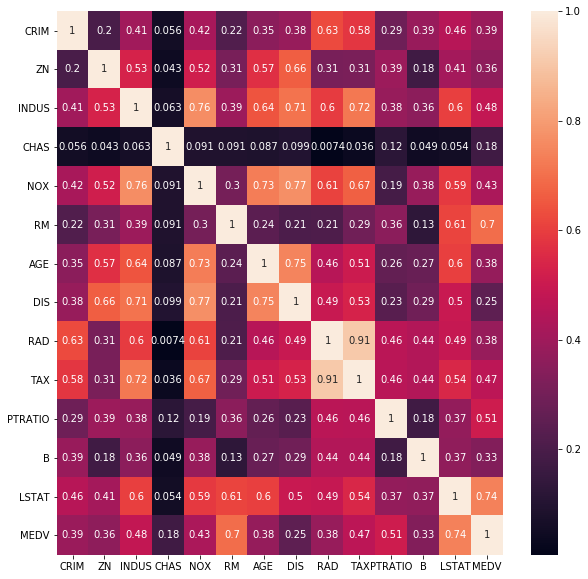

In [4]:
import seaborn as sns

#使用绝对值，更容易看去相关系数大小
corr=df.corr().abs()

plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

1. 我将相关系数的值都用绝对值表示，由此，从上图可以看出
 1. RM、LSATA跟MEDV有较强相关性
 2. PRTRATIO、INDUS、TASX跟MEDV有较弱的相关性
2. 故我使用以上这几个变量来实现线性回归
3. 接下来对数据处理

In [5]:
#增加INDUS后均方误差未明显变小，为简化模型，故舍弃
#同上TAX也不行，均方误差更高了
#RM^2不行,使用后均方误差更高了
#我使用二次项时给梯度算法添加正则化，发现均方误差明显下降，推测出现过拟合现象
df['RM^2']=df['RM']**2
df['RM^3']=df['RM']**3
df['LSTAT^2']=df['LSTAT']**2
#加上RM^2*LSTAT均方误差更小，但拟合效果更差，推测出现过拟合情况
df['RM^2*LSTAT']=df['RM^2']*df['LSTAT']   
df['LSTAT^3']=df['LSTAT']**3
#不行
df['LSTAT_PTRATIO']=df['LSTAT']*df['PTRATIO']
#不行
df['RM_LSTAT']=df['RM']*df['LSTAT']
df['RM_PTRATIO']=df['RM']*df['PTRATIO']
df['PTRATIO^2']=df['PTRATIO']*df['PTRATIO']


#PS,之前我搞出过一组均方误差只有30（一条波动较小的曲线）的，然后我忘了调用的是哪个变量了，再试就试不出了
#试了试很多组，最后结果均方误差较小且模型相对不复杂的就是这组了
data=np.array(df[['LSTAT','RM','PTRATIO','RM_LSTAT','LSTAT^2','MEDV']])
#var为变量个数
var=data.shape[1]
#初始化线性回归对象
#这是使用梯度下降法
regreGD=Regression(var)
#这是使用最小二乘法
regreOLS=Regression(var)
#分割训练集和测试集
train_set=data[:401]
train_X=train_set[:,:-1]
train_y=train_set[:,-1]
test_set=data[402:]
test_X=test_set[:,:-1]
test_y=test_set[:,-1]

#以OLS结尾是用于最小二乘法的
train_X_OLS=train_X[:,:]
train_y_OLS=train_y[:]
test_X_OLS=test_X[:,:]
test_y_OLS=test_y[:]


#调用Regression对象里的normalize方法使变量归一化
train_X=regreGD.normalize(train_X)
test_X=regreGD.normalize(test_X)

#在变量第一列插上1
train_X=np.insert(train_X,0,1,axis=1)
test_X=np.insert(test_X,0,1,axis=1)
train_X_OLS=np.insert(train_X_OLS,0,1,axis=1)
test_X_OLS=np.insert(test_X_OLS,0,1,axis=1)

均方误差为515.3327


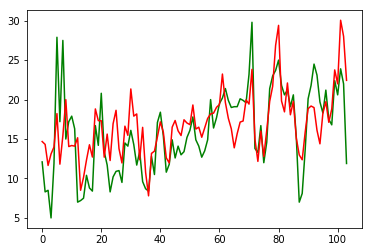

In [6]:
#使用最小二乘法
#不知为何使用最小二乘法的均方误差总会很高，推测可能为正则化做得不好
regreOLS.OLSRegression(10000,train_X_OLS,train_y_OLS)
mse=regreOLS.mse(test_X,test_y)
print('均方误差为%.04f'%mse)
plt.plot(range(0,test_y.shape[0]),test_y_OLS,c='green')
plt.plot(range(0,test_y.shape[0]),regreOLS.f(test_X_OLS),c='red')

- 最小二乘法看起来拟合得海星，但是不知为何均方误差那么高

均方误差为152.9157


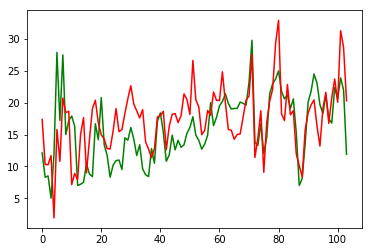

In [7]:
#梯度下降法
regreGD.GDRegression(0.00001,10000,train_X_GD=train_X,train_y_GD=train_y)
#算出均方误差和画出显示拟合情况的图
mse=regreGD.mse(test_X,test_y)
print('均方误差为%.04f'%mse)
plt.plot(range(0,test_y.shape[0]),test_y,c='green')
plt.plot(range(0,test_y.shape[0]),regreGD.f(test_X)-10,c='red')
#这里不清楚为什么预测结果要减10才能拟合上去

- 不知为何当我使用梯度下降法时，我得出的预测结果要减去10~15才能较好拟合
- 而且在10~60这段的一些数据总是拟合不好，总会预测偏大